In [1]:
# Подключаемся к гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.12.0
!pip install pandas==1.4.4
!pip install numpy==1.22.4
!pip install matplotlib==3.7.1
!pip install tqdm==4.65.0
!pip install torch==2.0.0
!pip install scikit-learn==1.2.2
!pip install nltk==3.8.1
!pip install transformers==4.28.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.4.4 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looki

In [42]:
import json
import os
import random

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import re
import pickle
import tqdm
from tqdm import tqdm, trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score

import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import backend as K

import torch

import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def print_allocated_cuda_memory():
  print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))

In [5]:
# Устанавливаем seed для воспроизводимости результатов
SEED = 11

def set_seed_for_tensorflow(seed: int = 42):

  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  random.seed(seed)

  tensorflow.random.set_seed(seed)
  tensorflow.keras.utils.set_random_seed(seed)
  session_conf = tensorflow.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  tensorflow.compat.v1.set_random_seed(seed)
  sess = tensorflow.compat.v1.Session(graph=tensorflow.compat.v1.get_default_graph(), config=session_conf)
  K.set_session(sess)
    
  print(f"Random seed set as {seed}")

def set_seed_for_torch(seed: int = 42) -> None:

  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  random.seed(seed)

  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.cuda.manual_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # torch.backends.cudnn.enabled = False
  
  transformers.set_seed(SEED)
  print(f"Random seed set as {seed}")


In [6]:
path_to_dir='/content/drive/MyDrive/nlp_test_task_kontur/'

In [ ]:
# Будем использовать 2 тага, I-тагом будем помечать те токены, которые должны войти в extracted_part,
# остальные токены помечаем O-тагом
list_of_tags = ['O', 'I'] 
n_tags = len(list_of_tags)

# Функции, необходимые для дальнейших вычислений

In [7]:
# Функция для сохранения датафрейма в файл
def save_to_file(result, columns, path_to_file):
  new = pd.DataFrame(data=result,
                     columns=columns)
  if os.path.exists(path_to_file)==True:
    df=pd.read_csv(path_to_file)
    df.drop('Unnamed: 0', axis = 1, inplace=True)
    new = pd.DataFrame(data=result,
                       columns=columns)
    df=df.append(new)
  else:
    df=new
  df.to_csv(path_to_file)

In [8]:
# Функция создания словаря токенов для GRU модели 
def get_dict_map(tokenized_data):
  all_tokens = []
  for sequence in tokenized_data:
    all_tokens += sequence

  vocabulary = list(set(all_tokens))
    
  token2idx = {token:(idx+2) for  idx, token in enumerate(vocabulary)}
  token2idx['[PAD]'] = 0
  token2idx['[UNKNOWN]'] = 1

  idx2token = {idx:token  for  token, idx in token2idx.items()}

  return token2idx, idx2token

In [9]:
# Функция для преобразования токенов в числа с помощью словаря
def convert_text_to_vector(tokenized_text, vocabulary):
  data=[]
  for word in tokenized_text:
    if vocabulary.get(word):
      data.append(vocabulary[word])
    else:
      data.append(1)
  return data

In [10]:
# Функция для создания тагов (или tags). 
# (Помечаем 1 те токены, которые соответствуют extracted_part)
def tagging_text(tokenized_text, tokenized_extracted_part):

  tagged_text = [0]*len(tokenized_text)

  if len(tokenized_extracted_part) < 2:
    return tagged_text

  text_token_idx = 0
  part_len = len(tokenized_extracted_part)

  train_part_of_text = ''
  for j in range(part_len):
      train_part_of_text += tokenized_extracted_part[j]
  
  for idx, token in enumerate(tokenized_text):

    if tokenized_extracted_part[0] in token:
      part_of_text = ''
      for i in range(idx, idx+part_len):
        part_of_text += tokenized_text[i]
      if train_part_of_text in part_of_text:

        part_of_text2 = ''
        for k in range(idx, idx+part_len-1):
          part_of_text2 += tokenized_text[k]
      
        if train_part_of_text in part_of_text2:
          tagged_text[idx:idx+part_len-1] = [1]*(part_len-1)
        else:
          tagged_text[idx:idx+part_len] = [1]*(part_len)
        break
    
  return tagged_text

In [64]:
# Функция для нахождения answer_start, answer_end по найденному фрагменту текста.
def find_extracted_parts_of_texts(extracted_parts, data):
  result = []
  for part_idx, part in enumerate(extracted_parts):
    if part=='':
      result.append({'text': [''],
                   'answer_start': [0], 
                   'answer_end': [0]})
    else:
      spaces_indices = []
      text = data[part_idx]['text']
      for symbol_idx, symbol in enumerate(text):
        if symbol==' ':
          spaces_indices.append(symbol_idx)

          
      part_without_spaces = re.sub(' ', '', part)
      text_without_spaces = re.sub(' ', '', text)

      answer_start = text_without_spaces.find(part_without_spaces)
      for idx in spaces_indices:
        if idx <= answer_start:
          answer_start += 1

      answer_end = answer_start + len(part)
      for idx in spaces_indices:
        if answer_start < idx < answer_end:
          answer_end += 1
      if answer_start == -1:
        result.append({'text': [''],
                   'answer_start': [0], 
                   'answer_end': [0]})
      else:
        result.append({'text': [data[part_idx]['text'][answer_start:answer_end]],
                       'answer_start': [answer_start], 
                       'answer_end': [answer_end]})
  return result

In [12]:
# Функция для подсчета точности (сколько правильно выявленных фрагментов текста было получено)
def calculate_accuracy_of_exctracted_parts(extracted_parts, data):
  result = []
  for idx, part in enumerate(extracted_parts):
    true_part = re.sub(' ', '', data[idx]['extracted_part']['text'][0])
    if re.sub(' ', '', part) == true_part:
      result.append(1)
    else:
      print('\npredicted_part:', re.sub(' ', '', part))
      print('extracted_part:', true_part)
      result.append(0)
  result = np.array(result)
  accuracy = result.mean()
  return accuracy

# Загрузка данных

In [14]:
try:
  
  with open(path_to_dir+"solution/dataset/train.json", 'r', encoding='utf-8') as f:
    train_data = json.load(f)

  with open(path_to_dir+"solution/dataset/test.json", 'r', encoding='utf-8') as f:
    test_data = json.load(f)

except FileNotFoundError as e:
  print(e)

In [15]:
train_data_len = len(train_data)
test_data_len = len(test_data)

print('Размер обучающей выборки:', train_data_len)
print('Размер тестовой выборки:', test_data_len)
print('Процентное соотношение тестовой выборки к обучающей:', test_data_len/train_data_len*100)

Размер обучающей выборки: 1799
Размер тестовой выборки: 318
Процентное соотношение тестовой выборки к обучающей: 17.676486937187327


# Применение GRU модели

In [18]:
set_seed_for_tensorflow(SEED)

Random seed set as 11


Обучим модель GRU на CPU.

In [ ]:
os.environ['CUDA_VISBLE_DEVICE'] = ''

In [40]:
def get_gru_model(input_dim, output_dim, input_length, n_tags, learning_rate=0.001):
    model = Sequential()

    # Слой Embedding
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Слой bidirectional GRU
    model.add(Bidirectional(GRU(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Слой timeDistributed Layer (обеспечивает выход формата many-to-many)
    model.add(Dense(output_dim, activation="relu"))
    model.add(TimeDistributed(Dense(n_tags, activation='softmax')))

    #Optimiser 
    optimizer = Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

## Обработка данных

In [19]:
tokenized_train_texts_with_labels = [nltk.word_tokenize(example['label']+' '+example['text']) for example in train_data]
tokenized_extracted_parts = [nltk.word_tokenize(example['extracted_part']['text'][0]) for example in train_data]

In [20]:
tokenized_test_texts_with_labels = [nltk.word_tokenize(example['label']+' '+example['text']) for example in test_data]

In [23]:
token2idx, idx2token = get_dict_map(tokenized_train_texts_with_labels+tokenized_test_texts_with_labels)

In [25]:
encoded_train_texts_with_labels = [convert_text_to_vector(text, token2idx) for text in tokenized_train_texts_with_labels]
encoded_train_tags = [tagging_text(tokenized_train_texts_with_labels[idx], tokenized_extracted_parts[idx]) for idx in range(train_data_len)]

In [26]:
encoded_test_texts_with_labels = [convert_text_to_vector(text, token2idx) for text in tokenized_test_texts_with_labels]

In [27]:
print("Maximum train texts tokens length: {}".format(len(max((encoded_train_texts_with_labels), key=len))))
print("Minimum train texts tokens length: {}".format(len(min((encoded_train_texts_with_labels), key=len))))
lengths = [len(x) for x in encoded_train_texts_with_labels]
print("Mean train texts tokens length: {}".format(np.mean(lengths)))

Maximum train texts tokens length: 786
Minimum train texts tokens length: 99
Mean train texts tokens length: 335.11617565314066


In [29]:
texts_maxlen = 335

encoded_train_texts_with_labels = pad_sequences(encoded_train_texts_with_labels, maxlen=texts_maxlen, truncating='post', padding='post')
encoded_train_tags = pad_sequences(encoded_train_tags, maxlen=texts_maxlen, padding='post', truncating='post')

In [30]:
encoded_test_texts_with_labels = pad_sequences(encoded_test_texts_with_labels, maxlen=texts_maxlen, truncating='post', padding='post')

In [34]:
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_data.pickle', 'wb') as f:
  pickle.dump(encoded_train_texts_with_labels, f)
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_tags.pickle', 'wb') as f:
  pickle.dump(encoded_train_tags, f)
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_test_data.pickle', 'wb') as f:
  pickle.dump(encoded_test_texts_with_labels, f)
with open(path_to_dir+'solution/gru_transformed_data/vocabulary.pickle', 'wb') as f:
  pickle.dump(idx2token, f)

## Разделение данных на обучающую и валидационную выборку

In [35]:
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_data.pickle', 'rb') as f:
  encoded_train_texts_with_labels=pickle.load(f)
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_tags.pickle', 'rb') as f:
  encoded_train_tags=pickle.load(f)
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_test_data.pickle', 'rb') as f:
  encoded_test_texts_with_labels=pickle.load(f)

In [36]:
train_tokens, val_tokens, train_tags, val_tags = train_test_split(encoded_train_texts_with_labels, encoded_train_tags, test_size = 0.2, random_state = SEED)

train_input_tags = np.array([to_categorical(i, num_classes=n_tags) for i in train_tags])
val_input_tags = np.array([to_categorical(i, num_classes=n_tags) for i in val_tags])

In [37]:
def find_percentage_of_O_tags(tags):
  O_tag_summ = 0
  tags_summ = tags.shape[0]*tags.shape[1]

  for example in tags:
    for tag in example:
      if tag==0:
        O_tag_summ += 1
  print('Отношение O-тэгов к общему количеству тэгов в encoded_train_tags:', O_tag_summ/tags_summ)

In [38]:
find_percentage_of_O_tags(train_tags)

Отношение O-тэгов к общему количеству тэгов в encoded_train_tags: 0.9616317301608704


In [39]:
find_percentage_of_O_tags(val_tags)

Отношение O-тэгов к общему количеству тэгов в encoded_train_tags: 0.9611525704809287


Таким образом, необходимо, чтобы значение точности модели на обучающей выборке было > 0.96163173, а на валидационной > 0.96115257.

## Оптимизация гиперпараметров GRU модели 

In [ ]:
path_to_file = path_to_dir+'solution/gru_model_results.csv'
columns = ['Train loss', 'Train accuracy', 'Val accuracy', 'Epochs', 'Batch size', 'Output dim']

input_dim = len(token2idx)
output_dims = [32, 64, 128]
input_length = texts_maxlen
batch_size = 16
epochs = 10

for output_dim in tqdm(output_dims):
  
    model = get_gru_model(input_dim, output_dim, input_length, n_tags)
    model_history = model.fit(train_tokens, train_input_tags, shuffle=False, batch_size=batch_size, epochs=epochs, validation_data=(val_tokens, val_input_tags), verbose=0)
      
    val_accuracy = model_history.history['val_accuracy']
    epoch_idx = np.where(np.array(val_accuracy) == max(val_accuracy))[0][0]
    result = [[model_history.history['loss'][epoch_idx], model_history.history['accuracy'][epoch_idx],
               model_history.history['val_accuracy'][epoch_idx], epoch_idx+1, 
               batch_size, output_dim]]
    save_to_file(result, columns, path_to_file)

    del model
    K.clear_session() 
    tensorflow.compat.v1.reset_default_graph()
    set_seed_for_tensorflow(SEED)

 33%|███▎      | 1/3 [10:35<21:11, 635.57s/it]

Random seed set as 11


 67%|██████▋   | 2/3 [25:06<12:53, 773.94s/it]

Random seed set as 11


100%|██████████| 3/3 [51:35<00:00, 1031.78s/it]

Random seed set as 11


In [ ]:
if os.path.exists(path_to_file)==True:
  df=pd.read_csv(path_to_file)
  df.drop('Unnamed: 0', axis = 1, inplace=True)
df.head(15)

,Train loss,Train accuracy,Val accuracy,Epochs,Batch size,Output dim
0,0.009972,0.996449,0.989436,10,8,32
1,0.006735,0.997778,0.990556,10,8,64
2,0.006000,0.997789,0.990804,9,8,128
3,0.011359,0.995957,0.989386,10,16,32
4,0.016003,0.994142,0.988259,7,16,64
5,0.006273,0.997789,0.989527,10,16,128


In [ ]:
df[df['Val accuracy']==max(df['Val accuracy'])]

,Train loss,Train accuracy,Val accuracy,Epochs,Batch size,Output dim
2,0.006,0.997789,0.990804,9,8,128


Таким образом, наилучший результат на валидационной выборке показала модель с гиперпараметрами: epochs=9, batch_size=8, output_dim=128.

## Воспроизведение наилучшего результата и сохранение модели

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 335, 128)          3349248   
                                                                 
 bidirectional (Bidirectiona  (None, 335, 256)         198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 335, 128)          32896     
                                                                 
 time_distributed (TimeDistr  (None, 335, 2)           258       
 ibuted)                                                         
                                                                 
Total params: 3,580,546
Trainable params: 3,580,546
Non-trainable params: 0
_________________________________________________________________


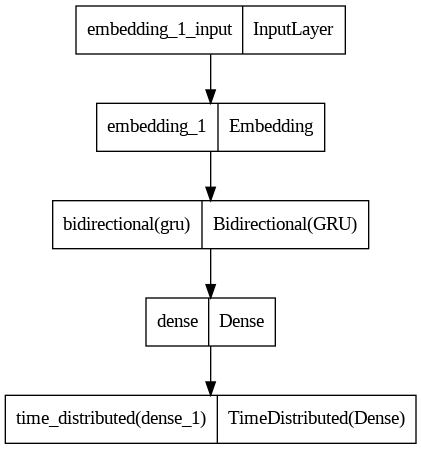

In [43]:
input_dim = len(token2idx)
output_dim = 128
input_length = texts_maxlen

model = get_gru_model(input_dim, output_dim, input_length, n_tags)
model.summary()
plot_model(model)

In [44]:
batch_size = 8
epochs = 9

model_history = model.fit(train_tokens, train_input_tags, batch_size=batch_size, verbose=1, shuffle = False, epochs=epochs, validation_data=(val_tokens, val_input_tags))

Epoch 1/9
180/180 [==============================] - 400s 2s/step - loss: 0.0937 - accuracy: 0.9727 - val_loss: 0.0411 - val_accuracy: 0.9839
Epoch 2/9
180/180 [==============================] - 443s 2s/step - loss: 0.0352 - accuracy: 0.9863 - val_loss: 0.0355 - val_accuracy: 0.9858
Epoch 3/9
180/180 [==============================] - 375s 2s/step - loss: 0.0251 - accuracy: 0.9905 - val_loss: 0.0360 - val_accuracy: 0.9886
Epoch 4/9
180/180 [==============================] - 328s 2s/step - loss: 0.0173 - accuracy: 0.9935 - val_loss: 0.0351 - val_accuracy: 0.9881
Epoch 5/9
180/180 [==============================] - 329s 2s/step - loss: 0.0134 - accuracy: 0.9951 - val_loss: 0.0329 - val_accuracy: 0.9901
Epoch 6/9
180/180 [==============================] - 328s 2s/step - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0367 - val_accuracy: 0.9900
Epoch 7/9
180/180 [==============================] - 324s 2s/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0345 - val_accuracy: 0.9909
Epoch 

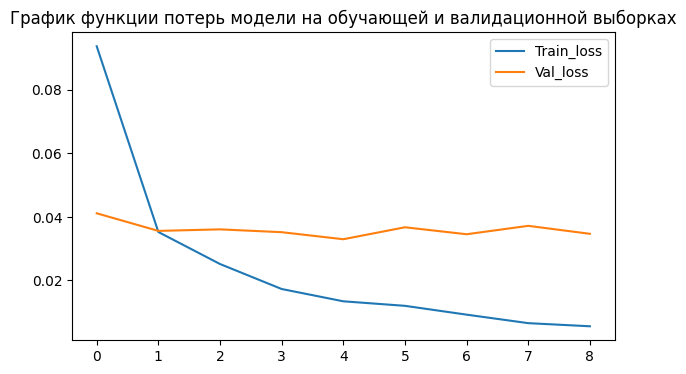

In [45]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(model_history.history['loss'], label='Train_loss')
ax.plot(model_history.history['val_loss'], label='Val_loss')
ax.set_title('График функции потерь модели на обучающей и валидационной выборках')
ax.legend().set_visible(True)

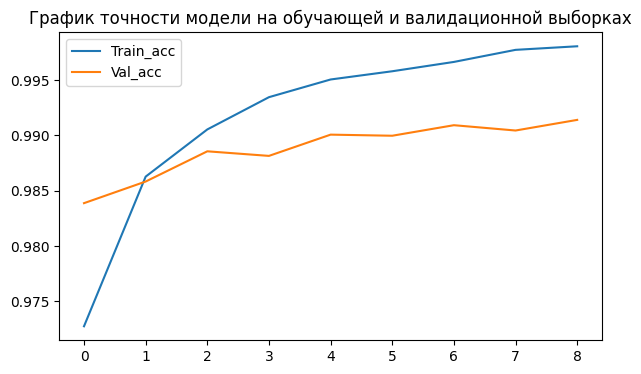

In [46]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(model_history.history['accuracy'], label='Train_acc')
ax.plot(model_history.history['val_accuracy'], label='Val_acc')
ax.set_title('График точности модели на обучающей и валидационной выборках')
ax.legend().set_visible(True)

In [47]:
model.save(path_to_dir+'solution/gru_model')

## Предсказание модели GRU 


In [48]:
# Функция преобразования полученных результатов модели в строки
def convert_from_tags_to_str(inputs, outputs, idx2token):
  result = []

  for input_vector, output_vector in zip(inputs, outputs):
    idx = 3
    extracted_words_ids = []
    while idx < len(output_vector):
      if output_vector[idx]==1:
        words_ids = []
        while (idx < len(output_vector)) and (output_vector[idx]!=0 or (idx+1 < len(output_vector) and 
                                                                        output_vector[idx]==0 and output_vector[idx+1]!=0)):
          words_ids.append(input_vector[idx])
          idx += 1
        extracted_words_ids.append(words_ids)
      idx += 1

    if extracted_words_ids==[]:
      result.append('')
    else:
      extracted_str = ''
      extracted_part = max(extracted_words_ids)
      if len(extracted_part) > 1:
        for word_idx in extracted_part:
          extracted_str += idx2token[word_idx]
          extracted_str += ' '
      result.append(extracted_str)

  return result

In [50]:
with open(path_to_dir+'solution/gru_transformed_data/vocabulary.pickle', 'rb') as f:
  idx2token = pickle.load(f)

In [51]:
gru_model = tensorflow.keras.models.load_model(path_to_dir+'solution/gru_model')

### Предсказание модели на train data

In [52]:
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_data.pickle', 'rb') as f:
  encoded_train_texts_with_labels = pickle.load(f)
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_train_tags.pickle', 'rb') as f:
  encoded_train_tags = pickle.load(f)

In [53]:
gru_model_predictions = np.argmax(gru_model.predict(encoded_train_texts_with_labels), axis=2)

57/57 [==============================] - 14s 230ms/step


In [54]:
gru_model_predictions[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
predicted_parts = convert_from_tags_to_str(encoded_train_texts_with_labels, gru_model_predictions, idx2token)

In [56]:
accuracy_of_exctracted_parts = calculate_accuracy_of_exctracted_parts(predicted_parts, train_data)


predicted_part: Размеробеспеченияисполненияконтрактаустанавливаетсявразмере5(пять)процентовотцены,покоторойзаключаетсяконтрактисоставляет_________
extracted_part: Размеробеспеченияисполненияконтрактаустанавливаетсявразмере5(пять)процентовотцены,покоторойзаключаетсяконтрактисоставляет___

predicted_part: ИсполнительвнесобеспечениеисполненияКонтрактавразмере___,чтосоставляет5%ЦеныКонтрактавформебезотзывнойнезависимойгарантии/путем
extracted_part: ИсполнительвнесобеспечениеисполненияКонтрактавразмере___,чтосоставляет5%ЦеныКонтрактавформебезотзывнойнезависимойгарантии

predicted_part: Размеробеспечениягарантийныхобязательствсоставляет:0,00%отначальной(максимальной)ценыконтракта,чтосоставляет0,00рублей.
extracted_part: Размеробеспеченияисполненияконтракта(договора)составляет:0,50%отцены

predicted_part: ОбеспечениеисполненияКонтрактаустанавливаетсявразмере5%отцены,покоторойзаключаетсяКонтракт
extracted_part: ОбеспечениеисполненияКонтрактаустанавливаетсявразмере5%отцены,покоторойзаключается

In [57]:
# Выведем точность полученных фрагментов текста
accuracy_of_exctracted_parts

0.8265703168426903

### Предсказание модели на test data

In [58]:
with open(path_to_dir+'solution/gru_transformed_data/gru_encoded_test_data.pickle', 'rb') as f:
  encoded_test_texts_with_labels = pickle.load(f)

In [59]:
gru_model_predictions = np.argmax(gru_model.predict(encoded_test_texts_with_labels), axis=2)

10/10 [==============================] - 3s 278ms/step


In [60]:
predicted_parts = convert_from_tags_to_str(encoded_test_texts_with_labels, gru_model_predictions, idx2token)

In [ ]:
extracted_parts_of_texts = find_extracted_parts_of_texts(predicted_parts, test_data)

In [68]:
predictions = test_data
for idx, example in enumerate(predictions):
  predictions[idx]['extracted_part'] = extracted_parts_of_texts[idx]

In [72]:
predictions[0]

{'id': 762883279,
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Фед

In [70]:
# Сохранение полученных предсказаний для тестового датасета в json файл
with open(path_to_dir+'predictions.json', "w", encoding="utf-8") as file:
    json.dump(predictions, file)

# Применение модели BERT

In [ ]:
set_seed_for_torch(SEED)

Random seed set as 11


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [ ]:
from transformers import BertTokenizerFast 
# from transformers import DataCollatorForTokenClassification 
from transformers import BertForTokenClassification
from transformers import AdamW

model_name = 'bert-base-multilingual-cased'

In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
print(device)

cuda


In [ ]:
# Download bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name)

## Обработка и сохранение данных

In [ ]:
tokenized_train_labels = [nltk.word_tokenize(example['label']) for example in train_data]
tokenized_train_texts = [nltk.word_tokenize(example['text']) for example in train_data]
tokenized_extracted_parts = [nltk.word_tokenize(example['extracted_part']['text'][0]) for example in train_data]

In [ ]:
encoded_train_tags = [tagging_text(tokenized_train_texts[idx], tokenized_extracted_parts[idx]) for idx in range(train_data_len)]

In [ ]:
def tokenize_and_align_labels(tokenized_labels, tokenized_texts, tags, label_all_tokens=True): 
  encoded_inputs = list(map(lambda label, text: tokenizer.encode_plus(label, text, max_length=512, pad_to_max_length=True, 
                                                                      return_attention_mask = True, is_split_into_words=True), 
                            tokenized_labels, tokenized_texts))
  for i, labels in enumerate(tags): 
    word_ids = encoded_inputs[i].word_ids() 
    previous_word_idx = None 
    label_ids = []
    token_idx = 0
    while token_idx < len(word_ids):
      if word_ids[token_idx] is None:
        if encoded_inputs[i]['input_ids'][token_idx] == 101:
          while encoded_inputs[i]['input_ids'][token_idx] != 102:
            label_ids.append(-100)
            token_idx += 1
        label_ids.append(-100)
      elif word_ids[token_idx] != previous_word_idx:
        label_ids.append(labels[word_ids[token_idx]]) 
      else: 
        label_ids.append(labels[word_ids[token_idx]] if label_all_tokens else -100) 
      
      previous_word_idx = word_ids[token_idx] 
      token_idx += 1
      
    encoded_inputs[i]["labels"] = label_ids
    
 
  return encoded_inputs 

In [ ]:
encoded_inputs = tokenize_and_align_labels(tokenized_train_labels, tokenized_train_texts, encoded_train_tags, label_all_tokens=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train_inputs, val_inputs = train_test_split(encoded_inputs, test_size = 0.2, random_state = SEED)

In [ ]:
with open(path_to_dir+'solution/bert_train_inputs.pickle', 'wb') as f:
  pickle.dump(train_inputs, f)
with open(path_to_dir+'solution/bert_val_inputs.pickle', 'wb') as f:
  pickle.dump(val_inputs, f)

In [ ]:
def find_percentage_of_O_tags_for_bert(inputs):
  O_tags_count = 0
  not_ignored_tokens = 0
  for input in inputs:
    O_tags_count += len(np.where(np.array(input['labels'])==0)[0])
    not_ignored_tokens += len(np.where(np.array(input['labels'])!=-100)[0])
  print('Отношение O-тэгов к общему количеству тэгов:', O_tags_count/not_ignored_tokens)

In [ ]:
find_percentage_of_O_tags_for_bert(train_inputs)

Отношение O-тэгов к общему количеству тэгов: 0.9506640303605967


In [ ]:
find_percentage_of_O_tags_for_bert(val_inputs)

Отношение O-тэгов к общему количеству тэгов: 0.9503948738301898


Таким образом, необходимо, чтобы значение точности модели на обучающей выборке было > 0.950664, а на валидационной > 0.95039487.

In [ ]:
# Количество слов в примерах без учёта subtokens
inputs_excluding_subtokens = tokenize_and_align_labels(tokenized_train_labels, tokenized_train_texts, encoded_train_tags, label_all_tokens=False)
words_counts = []
for input in inputs_excluding_subtokens:
  words_counts.append(len(np.where(np.array(input['labels'])==0)[0]))
print(min(words_counts), np.mean(np.array(words_counts)), max(words_counts))

76 224.46136742634798 291


## Обучение модели BERT

In [ ]:
with open(path_to_dir+'solution/bert_train_inputs.pickle', 'rb') as f:
  train_inputs=pickle.load(f)
with open(path_to_dir+'solution/bert_val_inputs.pickle', 'rb') as f:
  val_inputs=pickle.load(f)

In [ ]:
train_inputs_ids = [input['input_ids'] for input in train_inputs] 
train_token_type_ids = [input['token_type_ids'] for input in train_inputs] 
train_masks = [input['attention_mask'] for input in train_inputs]
train_labels = [input['labels'] for input in train_inputs]

val_inputs_ids = [input['input_ids'] for input in val_inputs] 
val_token_type_ids = [input['token_type_ids'] for input in val_inputs] 
val_masks = [input['attention_mask'] for input in val_inputs]
val_labels = [input['labels'] for input in val_inputs]

In [ ]:
# Преобразование всех наших данных в тензоры pytorch, требуемый тип данных для нашей модели
train_inputs = torch.tensor(train_inputs_ids)
validation_inputs = torch.tensor(val_inputs_ids)

train_token_types = torch.tensor(train_token_type_ids)
validation_token_types = torch.tensor(val_token_type_ids)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(val_masks)

In [ ]:
# Подготовка данных для DataLoader
train_dataset = TensorDataset(train_inputs, train_token_types, train_masks, train_labels)
train_sampler = SequentialSampler(train_dataset)

validation_dataset = TensorDataset(validation_inputs, validation_token_types, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_dataset)

In [ ]:
def compute_accuracy(preds, labels): 
  pred_logits = np.argmax(preds, axis=2)
  # We remove all the values where the label is -100
  predictions = []
  for prediction, label in zip(pred_logits, labels):
    predictions += [eval_preds for (eval_preds, l) in zip(prediction, label) if l != -100]
  predictions = np.array(predictions)
    
  true_labels = []
  for prediction, label in zip(pred_logits, labels):
    true_labels += [l for (eval_preds, l) in zip(prediction, label) if l != -100]
  true_labels = np.array(true_labels)

  accuracy = accuracy_score(true_labels, predictions) 
  return accuracy

In [ ]:
def train_epoch(model, optimizer, train_dataloader):
  # Установим нашу модель в режим обучения
  model.train()  
  # Отслеживание переменных
  losses_set = []
  accuracy_set = []

  for batch in train_dataloader:
    # Добавить пакет в GPU
    # Распакуйте входные данные из нашего загрузчика данных
    b_input_ids, b_token_type_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    
    # Forward pass
    model_result = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)

    loss=model_result[0] 

    # Backward pass
    loss.backward()
    # Обновите параметры и сделайте шаг, используя вычисленный градиент
    optimizer.step()

    loss = loss.detach().cpu()
    losses_set.append(loss.item())

    logits = model_result[1] 
    # Переместить logits и labels на CPU
    logits = logits.detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()
    accuracy = compute_accuracy(logits, labels)  
    accuracy_set.append(accuracy)

    b_input_ids, b_token_type_ids = b_input_ids.detach().cpu(), b_token_type_ids.detach().cpu()
    b_input_mask, b_labels =  b_input_mask.detach().cpu(), b_labels.detach().cpu()
    # Очистите градиенты (по умолчанию они накапливаются)
    optimizer.zero_grad()


  avg_loss = np.array(losses_set).mean()
  avg_accuracy = np.array(accuracy_set).mean()

  torch.cuda.empty_cache()
  # gc.collect()

  return (avg_loss, avg_accuracy)
      

In [ ]:
def evaluate_model(model, val_dataloader):
  # Поместите модель в режим валидации
  model.eval()
  # Tracking variables 
  losses_set = []
  accuracy_set = []
  # Evaluate data for one epoch
  for batch in val_dataloader:

    b_input_ids, b_token_type_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      # Forward pass, рассчитать логит-прогнозы
      model_result = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)
    
    loss = model_result[0].detach().cpu()
    losses_set.append(loss.item())
    # Переместить logits и labels на CPU
    logits = model_result[1].detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()
    accuracy = compute_accuracy(logits, labels)  
    accuracy_set.append(accuracy)   

    b_input_ids, b_token_type_ids = b_input_ids.detach().cpu(), b_token_type_ids.detach().cpu()
    b_input_mask, b_labels =  b_input_mask.detach().cpu(), b_labels.detach().cpu()
   

  avg_loss = np.array(losses_set).mean()
  avg_accuracy = np.array(accuracy_set).mean()

  torch.cuda.empty_cache()

  return (avg_loss, avg_accuracy)
  

In [ ]:
def fine_tune_model(epochs, model, train_dataloader, validation_dataloader, optimizer):
   
  train_losses_set, train_accuracy_set = [], []
  val_losses_set, val_accuracy_set = [], []

  for epoch in trange(epochs, desc='Epoch'): 

    # Обучение модели
    train_loss, train_accuracy = train_epoch(model, optimizer, train_dataloader)
    train_losses_set.append(train_loss)
    train_accuracy_set.append(train_accuracy)

    # Валидация модели
    val_loss, val_accuracy = evaluate_model(model, validation_dataloader)
    val_losses_set.append(val_loss)
    val_accuracy_set.append(val_accuracy)

    print('\nEpoch', epoch+1, '- train_loss:', train_loss, '- train_accuracy:', train_accuracy,
          '- val_loss:', val_loss, '- val_accuracy:', val_accuracy)

  return {'train_loss' : train_losses_set,
          'train_accuracy' : train_accuracy_set,
          'val_loss' : val_losses_set,
          'val_accuracy' : val_accuracy_set
          }


### Оптимизация гиперпараметров модели BERT

In [ ]:
bert_model = BertForTokenClassification.from_pretrained(model_name, num_labels=n_tags)
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  print(bert_model.cuda())
else:
  print(bert_model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
weight_decay_rates=[0.1, 0.01]
learning_rates = [2e-5]
batch_sizes = [8, 16]

In [ ]:
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_sizes[0])
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_sizes[0])

In [ ]:
# Количество эпох обучения
epochs = 10

learning_rate=learning_rates[0]
weight_decay_rate=weight_decay_rates[0]
# BERT fine-tuning parameters
param_optimizer = list(bert_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': weight_decay_rate},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

model_history = fine_tune_model(epochs, bert_model, train_dataloader, validation_dataloader, optimizer)

Epoch:  10%|█         | 1/10 [02:41<24:17, 162.00s/it]


Epoch 1 - train_loss: 0.0652542151704741 - train_accuracy: 0.9771047248941623 - val_loss: 0.023755715963327224 - val_accuracy: 0.991295320180589


Epoch:  20%|██        | 2/10 [05:24<21:36, 162.03s/it]


Epoch 2 - train_loss: 0.017881692925422816 - train_accuracy: 0.9935232169295631 - val_loss: 0.016980262033434376 - val_accuracy: 0.9947031487616496


Epoch:  30%|███       | 3/10 [08:05<18:51, 161.67s/it]


Epoch 3 - train_loss: 0.01054621839753559 - train_accuracy: 0.9964402157862255 - val_loss: 0.018977816391270608 - val_accuracy: 0.995008132122631


Epoch:  40%|████      | 4/10 [10:45<16:07, 161.27s/it]


Epoch 4 - train_loss: 0.00845145230357755 - train_accuracy: 0.9970352530831368 - val_loss: 0.019302364805480466 - val_accuracy: 0.9941380852552429


Epoch:  50%|█████     | 5/10 [13:26<13:24, 160.99s/it]


Epoch 5 - train_loss: 0.007103072331665317 - train_accuracy: 0.9973159844107238 - val_loss: 0.018124785097057207 - val_accuracy: 0.99580215087804


Epoch:  60%|██████    | 6/10 [16:06<10:43, 160.84s/it]


Epoch 6 - train_loss: 0.004681156285692446 - train_accuracy: 0.998418069147126 - val_loss: 0.019035005027156635 - val_accuracy: 0.9957771149332898


Epoch:  70%|███████   | 7/10 [18:47<08:02, 160.76s/it]


Epoch 7 - train_loss: 0.00633420648767545 - train_accuracy: 0.9978726722122376 - val_loss: 0.020276416755384868 - val_accuracy: 0.994184110277634


Epoch:  80%|████████  | 8/10 [21:28<05:21, 160.69s/it]


Epoch 8 - train_loss: 0.005169183146083217 - train_accuracy: 0.9982327753551982 - val_loss: 0.02307651415806807 - val_accuracy: 0.9948520792661183


Epoch:  90%|█████████ | 9/10 [24:08<02:40, 160.63s/it]


Epoch 9 - train_loss: 0.006102854106373141 - train_accuracy: 0.9980417062334804 - val_loss: 0.02029844215430785 - val_accuracy: 0.9939744387011209


Epoch: 100%|██████████| 10/10 [26:49<00:00, 160.92s/it]


Epoch 10 - train_loss: 0.003359007224147111 - train_accuracy: 0.9988537488626636 - val_loss: 0.016856193192021845 - val_accuracy: 0.9955875270263378


In [ ]:
columns = ['Train loss', 'Train accuracy', 'Val accuracy', 'Epochs', 'Learning rate', 'Weight decay rate', 'Batch size']
path_to_file = path_to_dir+'solution/bert_model_results.csv'

In [ ]:
val_accuracy = model_history['val_accuracy']
epoch_idx = np.where(np.array(val_accuracy) == max(val_accuracy))[0][0]
result = [[model_history['train_loss'][epoch_idx], model_history['train_accuracy'][epoch_idx],
           model_history['val_accuracy'][epoch_idx], epoch_idx+1, learning_rate,
           weight_decay_rate, batch_sizes[0]]]
save_to_file(result, columns, path_to_file)

In [ ]:
try:
  bert_model = bert_model.cpu()
  del bert_model
  del optimizer
except ValueError as e:
  print(e)

In [ ]:
# Вывод занятой памяти на GPU
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.015869GB


Даже после очищения памяти GPU и удаления модели, память GPU не равна 0. Поэтому для воспроизводимости результатов необходимо перезагружать среду выполнения.

In [ ]:
if os.path.exists(path_to_file)==True:
  df=pd.read_csv(path_to_file)
  df.drop('Unnamed: 0', axis = 1, inplace=True)
df.head(30)

,Train loss,Train accuracy,Val accuracy,Epochs,Learning rate,Weight decay rate,Batch size
0,0.006099,0.997937,0.995788,6,0.00002,0.10,16
1,0.006099,0.997937,0.995788,6,0.00002,0.01,16
2,0.007103,0.997316,0.995802,5,0.00002,0.10,8


In [ ]:
df[df['Val accuracy']==max(df['Val accuracy'])]

,Train loss,Train accuracy,Val accuracy,Epochs,Learning rate,Weight decay rate,Batch size
2,0.007103,0.997316,0.995802,5,0.00002,0.1,8


Таким образом, максимальное значение точности на валидации набрала модель с гиперпараметрами: epochs=5, learning_rate=2e-5, weight_decay_rate=0.1, batch_size=8.

### Воспроизведение наилучшего результата и сохранение модели

In [ ]:
bert_model = BertForTokenClassification.from_pretrained(model_name, num_labels=n_tags)
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  print(bert_model.cuda())
else:
  print(bert_model)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [ ]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Количество эпох обучения
epochs = 5

learning_rate = 2e-5
weight_decay_rate = 0.1
# BERT fine-tuning parameters
param_optimizer = list(bert_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': weight_decay_rate},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

model_history = fine_tune_model(epochs, bert_model, train_dataloader, validation_dataloader, optimizer)

Epoch:  20%|██        | 1/5 [02:40<10:41, 160.42s/it]


Epoch 1 - train_loss: 0.0652542151704741 - train_accuracy: 0.9771047248941623 - val_loss: 0.023755715963327224 - val_accuracy: 0.991295320180589


Epoch:  40%|████      | 2/5 [05:22<08:03, 161.19s/it]


Epoch 2 - train_loss: 0.017881692925422816 - train_accuracy: 0.9935232169295631 - val_loss: 0.016980262033434376 - val_accuracy: 0.9947031487616496


Epoch:  60%|██████    | 3/5 [08:04<05:23, 161.91s/it]


Epoch 3 - train_loss: 0.01054621839753559 - train_accuracy: 0.9964402157862255 - val_loss: 0.018977816391270608 - val_accuracy: 0.995008132122631


Epoch:  80%|████████  | 4/5 [10:47<02:42, 162.29s/it]


Epoch 4 - train_loss: 0.00845145230357755 - train_accuracy: 0.9970352530831368 - val_loss: 0.019302364805480466 - val_accuracy: 0.9941380852552429


Epoch: 100%|██████████| 5/5 [13:29<00:00, 162.00s/it]


Epoch 5 - train_loss: 0.007103072331665317 - train_accuracy: 0.9973159844107238 - val_loss: 0.018124785097057207 - val_accuracy: 0.99580215087804


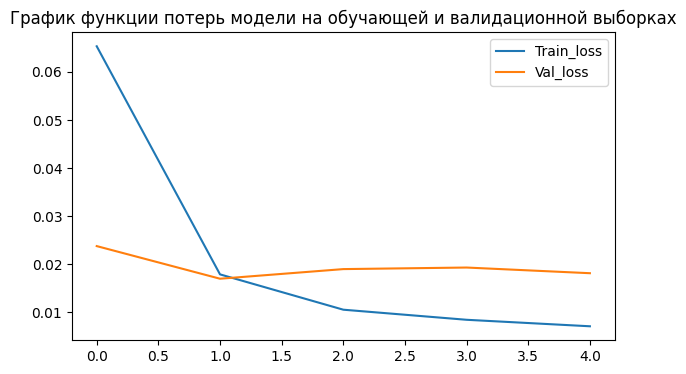

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(model_history['train_loss'], label='Train_loss')
ax.plot(model_history['val_loss'], label='Val_loss')
ax.set_title('График функции потерь модели на обучающей и валидационной выборках')
ax.legend().set_visible(True)

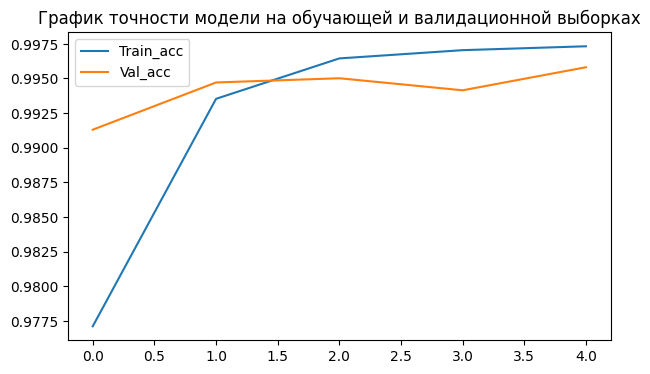

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(model_history['train_accuracy'], label='Train_acc')
ax.plot(model_history['val_accuracy'], label='Val_acc')
ax.set_title('График точности модели на обучающей и валидационной выборках')
ax.legend().set_visible(True)

In [ ]:
# Сохранение модели BERT
torch.save(bert_model, path_to_dir+'solution/bert_model')

## Предсказание модели BERT

In [ ]:
try:
  bert_model = bert_model.cpu()
  del bert_model
  del optimizer
except ValueError as e:
  print(e)

In [ ]:
# Загрузка обученной модели BERT
bert_model=torch.load(path_to_dir+'solution/bert_model')

In [ ]:
# Функция преобразования полученных результатов модели в строки 
def convert_from_tags_to_str(inputs_ids, outputs, tokenizer):
  result = []

  for input_vector, output_vector in zip(inputs_ids, outputs):
    idx = 0
    extracted_tokens_ids = []
    while idx < len(output_vector):
      if output_vector[idx]==1:
        tokens_ids = []
        while idx<len(output_vector) and (output_vector[idx]!=0 or (idx+1<len(output_vector) and output_vector[idx]==0 and output_vector[idx+1]!=0)):
          tokens_ids.append(idx)
          idx += 1
        extracted_tokens_ids.append(tokens_ids)
      idx += 1

    if extracted_tokens_ids==[]:
      result.append('')
    else:
      extracted_str = ''
      extracted_part = max(extracted_tokens_ids)
      if len(extracted_part) > 1:
        extracted_str = tokenizer.decode(input_vector[extracted_part[0]:extracted_part[-1]])
      result.append(extracted_str)

  return result

### Предсказание модели на train data

In [ ]:
tokenized_train_labels = [nltk.word_tokenize(example['label']) for example in train_data]
tokenized_train_texts = [nltk.word_tokenize(example['text']) for example in train_data]

In [ ]:
encoded_train_inputs = list(map(lambda label, text: tokenizer.encode_plus(label, text, max_length=512, pad_to_max_length=True, 
                                                                      return_attention_mask = True, is_split_into_words=True), 
                               tokenized_train_labels, tokenized_train_texts))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
inputs_ids = [input['input_ids'] for input in encoded_train_inputs] 
token_type_ids = [input['token_type_ids'] for input in encoded_train_inputs] 
masks = [input['attention_mask'] for input in encoded_train_inputs]

train_inputs = torch.tensor(inputs_ids)
train_token_types = torch.tensor(token_type_ids)
train_masks = torch.tensor(masks)

train_dataset = TensorDataset(train_inputs, train_token_types, train_masks)
train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=8)

In [ ]:
def predict_for_dataloader(model, dataloader):
  model.eval()
  predictions = []
  for batch in dataloader:
    b_input_ids, b_token_type_ids, b_input_mask = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      # Forward pass, рассчитать логит-прогнозы
      logits = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask)
    logits = list(logits[0].detach().cpu())

    if predictions!=[]:
      predictions += logits
    else:
      predictions = logits

    b_input_ids, b_token_type_ids, b_input_mask = b_input_ids.to('cpu'), b_token_type_ids.to('cpu'), b_input_mask.to('cpu')
    torch.cuda.empty_cache()

  predictions = [np.array(pred) for pred in predictions]
  return np.array(predictions)

In [ ]:
bert_model_predictions = predict_for_dataloader(bert_model, train_dataloader)

In [ ]:
predicted_tags = np.argmax(bert_model_predictions, axis=2)

In [ ]:
predicted_parts = convert_from_tags_to_str(inputs_ids, predicted_tags, tokenizer)

In [ ]:
accuracy_of_exctracted_parts = calculate_accuracy_of_exctracted_parts(predicted_parts, train_data)


predicted_part: Размеробеспеченияисполненияконтракта6593.25Российскийруб
extracted_part: Размеробеспеченияисполненияконтракта6593.25Российскийрубль

predicted_part: Поставщикдолженпредоставитьобеспечениеисполненияконтрактавразмере10%отценыКонтракта
extracted_part: Поставщикдолженпредоставитьобеспечениеисполненияконтрактавразмере10%отценыКонтракта.

predicted_part: Размеробеспеченияисполненияконтракта10.00
extracted_part: Размеробеспеченияисполненияконтракта10.00%

predicted_part: Размеробеспеченияисполненияконтракта10.00
extracted_part: Размеробеспеченияисполненияконтракта10.00%

predicted_part: Размеробеспеченияисполненияконтракта10.00
extracted_part: Размеробеспеченияисполненияконтракта10.00%

predicted_part: Размеробеспеченияисполненияконтрактаустанавливаетсявразмере5(пять)процентовотцены,покоторойзаключаетсяконтрактисоставляет_________(___________
extracted_part: Размеробеспеченияисполненияконтрактаустанавливаетсявразмере5(пять)процентовотцены,покоторойзаключаетсяконтрактисоставля

In [ ]:
# Выведем точность полученных фрагментов текста
accuracy_of_exctracted_parts

0.1773207337409672

# Вывод

Таким образом, при обучении на обучающей и валидационной выборках модель BERT показала точность выше, чем модель GRU. Однако после обратного преобразования полученных векторов в текст, её точность в определении фрагмента текста, чтобы он точно совпал с extracted part из обучающего датасета, оказалась намного ниже, чем у GRU. 
Поэтому среди данных моделей была выбрана GRU, с помощью неё и были сделаны предсказания для тестовой выборки.